# Мастерская. Проект по предсказанию сердечного приступа.

В данном проекте нам предстоит нам предстоит разработать модель машинного обучния, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке. 

В начале проекта нам доступен обучающий датасет и тестовый датасет, не содержащий правильных ответов. Метрика на тестовом датасете будет измерена в ходе проверки работы. Также нам доступен скрипт, с помощью которого будет измеряться финальная метрика вашей модели.

В данной работе мы сделаем следующие шаги:
- изучим предоставленные данные,
- проведем предобработку,
- исследования,
- объединение данных и выделение необходимых признаков,
- изучим взаимосвязь параметров между собой,
- построим модели,
- подобрем гипермараметры,
- выберем наиболее подходящую из них,
- подберем наиболее подходящую для проекта метрику,
- сделаем предсказание для тестовой выборки для отправки на проверку,
- кроме того, мы подготовим библиотеку и интерфейс к ней.

In [1]:
#импорты и константы

import numpy as np
import pandas as pd
import re
!pip install --upgrade matplotlib -q
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
!pip install --upgrade scikit-learn -q
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, make_scorer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC

!pip install phik -q
from phik import phik_matrix
from phik.report import plot_correlation_matrix


!pip install shap -q
import shap

RANDOM_STATE = 42
TEST_SIZE = 0.25

import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)

## Загрузка данных

В начале работы загрузим и изучим данные.

In [2]:
# функция для изучения данных
def describe_db(name):
    print(name.info())
    display(name.shape)
    display(name.head())
    print('Дубликаты:', name.duplicated().sum())
    print()
    print('Пропуски:')
    print(name.isna().sum())
    print()

In [3]:
train_X_y = pd.read_csv('./heart_train.csv')
describe_db(train_X_y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

(8685, 28)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


Дубликаты: 0

Пропуски:
Unnamed: 0                           0
Age                                  0
Cholesterol                          0
Heart rate                           0
Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Exercise Hours Per Week              0
Diet                                 0
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Sedentary Hours Per Day              0
Income                               0
BMI                                  0
Triglycerides                        0
Physical Activity Days Per Week    243
Sleep Hours Per Day                  0
Heart Attack Risk (Binary)           0
Blood sugar                          0
CK-MB                                0
Troponin                             0
Gender                               0
S

In [57]:
test_X_y = pd.read_csv('./heart_test.csv')
describe_db(test_X_y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

(966, 27)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


Дубликаты: 0

Пропуски:
Unnamed: 0                          0
Age                                 0
Cholesterol                         0
Heart rate                          0
Diabetes                           31
Family History                     31
Smoking                            31
Obesity                            31
Alcohol Consumption                31
Exercise Hours Per Week             0
Diet                                0
Previous Heart Problems            31
Medication Use                     31
Stress Level                       31
Sedentary Hours Per Day             0
Income                              0
BMI                                 0
Triglycerides                       0
Physical Activity Days Per Week    31
Sleep Hours Per Day                 0
Blood sugar                         0
CK-MB                               0
Troponin                            0
Gender                              0
Systolic blood pressure             0
Diastolic blood pressure  

Самое заметное в данных - они масштабированы. Скорее всего - в целях конфиденциальности. Так же скрыты и личные данные пациентов.

В данных тренировочных и тестовых наблюдаются колонки с неверными типами данных (float для целочисленных, скорее всего, колонок). Полных дубликатов не наблюдается, есть пропуски, в одинаковом количестве для разных столбцов. Предполагаю, что они возникли из-за отсутствия данных, а не из-за ошибок. Данных получено достаточно много: почти 9000 на обучение и почти 1000 значений в тестовой выборке. Предполагаю, что этого должно хватить на качественное обучение модели.

В целом, присутствует очень много колонок с различными характеристиками. В дальнейшем вникнем в их содержание, поправим форматы, примем решение по пропускам, исключим колонки, которые будут неверно влиять на обучение (скорее всего, под такое исключение попадет колонка с номером пациента, id и возможные утечки данных). Править мы будем только тренировочные данные, тестовые останутся без изменений.

## Предобработка данных

Для начала заменим названия столбцов на более корректно написанные

In [5]:
def to_snake_case(column_name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1\2', column_name)
    s2 = re.sub(r'[ ]+', '_', s1)
    return s2.lower().strip('_')

train_X_y.columns = [to_snake_case(col) for col in train_X_y.columns]

print(train_X_y.columns)

Index(['unnamed:_0', 'age', 'cholesterol', 'heart_rate', 'diabetes',
       'family_history', 'smoking', 'obesity', 'alcohol_consumption',
       'exercise_hours_per_week', 'diet', 'previous_heart_problems',
       'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income',
       'bmi', 'triglycerides', 'physical_activity_days_per_week',
       'sleep_hours_per_day', 'heart_attack_risk_(binary)', 'blood_sugar',
       'ck-mb', 'troponin', 'gender', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'id'],
      dtype='object')


Как уже выяснили выше, полных дубликатов в таблицах не обнаружено. Попробуем проверить, что будет, если исключить столбцы Unnamed и id из таблиц. Для начала проверим количество уникальных значений в этих столбцах.

In [6]:
def count_unique(column):
    print(column.name)
    print(len(column.unique()))

In [7]:
count_unique(train_X_y['unnamed:_0'])
count_unique(train_X_y['id'])

unnamed:_0
8685
id
8685


Видно, что нет дубликатов и пропусков в этих столбцах. Значит, эти значения уникальны и привязаны к каждому отдельному пациенту. Они могут негативно повлиять на обучение, например, если каким-то образом пациенты записаны не в случайном порядке, а сначала те, у кого был сердечный приступ, а потом те, у кого не было. Один столбец удалим сейчас, другой позже, пока оставим для удобства использования функций в исследовательском анализе данных.

In [8]:
train_X_y = train_X_y.drop(['unnamed:_0'], axis=1)
describe_db(train_X_y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8685 non-null   float64
 1   cholesterol                      8685 non-null   float64
 2   heart_rate                       8685 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8685 non-null   float64
 9   diet                             8685 non-null   int64  
 10  previous_heart_problems          8442 non-null   float64
 11  medication_use                   8442 non-null   float64
 12  stress_level        

(8685, 27)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


Дубликаты: 0

Пропуски:
age                                  0
cholesterol                          0
heart_rate                           0
diabetes                           243
family_history                     243
smoking                            243
obesity                            243
alcohol_consumption                243
exercise_hours_per_week              0
diet                                 0
previous_heart_problems            243
medication_use                     243
stress_level                       243
sedentary_hours_per_day              0
income                               0
bmi                                  0
triglycerides                        0
physical_activity_days_per_week    243
sleep_hours_per_day                  0
heart_attack_risk_(binary)           0
blood_sugar                          0
ck-mb                                0
troponin                             0
gender                               0
systolic_blood_pressure              0
d

Дубликатов нет даже после удаления ненужных столбцов. Теперь проверим содержимое единственного текстового столбца Gender.

In [9]:
train_X_y['gender'].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)

Опечаток нет, но мужской и женский пол для некоторых значений заменены на 1 и 0, соответственно. Сделаем эти значения единообразными.

In [10]:
train_X_y['gender'] = train_X_y['gender'].replace({'Female': 0.0, 'Male': 1.0}).astype(float).astype(int)

train_X_y['gender'].unique()

array([1, 0])

Заменим типы данных и для других столбцов c целыми числами, заодно заменим пропуски на значение -1. Заменять пропуски средними или наиболее частыми значениями мы не будем, так как это живые данные и не стоит выдумывать тут свои числа.

In [11]:
train_X_y.nunique()

age                                  77
cholesterol                         282
heart_rate                           87
diabetes                              2
family_history                        2
smoking                               2
obesity                               2
alcohol_consumption                   2
exercise_hours_per_week            7933
diet                                  4
previous_heart_problems               2
medication_use                        2
stress_level                         10
sedentary_hours_per_day            7933
income                             7808
bmi                                7933
triglycerides                       772
physical_activity_days_per_week       8
sleep_hours_per_day                   8
heart_attack_risk_(binary)            2
blood_sugar                         239
ck-mb                               679
troponin                            340
gender                                2
systolic_blood_pressure             100


In [12]:
train_X_y['stress_level'].unique()

array([ 8.,  9.,  6.,  3.,  7.,  1., 10., nan,  2.,  5.,  4.])

In [13]:
train_X_y['sleep_hours_per_day'].unique()

array([0.33333333, 0.83333333, 1.        , 0.        , 0.16666667,
       0.66666667, 0.50462124, 0.5       ])

In [14]:
for column in train_X_y.columns:
    if len(train_X_y[column].unique()) <= 11 and column!='sleep_hours_per_day':
        train_X_y[column] = train_X_y[column].fillna(-1).astype('int64')

In [15]:
train_X_y['sleep_hours_per_day'] = train_X_y['sleep_hours_per_day'].round(2)

In [16]:
describe_db(train_X_y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8685 non-null   float64
 1   cholesterol                      8685 non-null   float64
 2   heart_rate                       8685 non-null   float64
 3   diabetes                         8685 non-null   int64  
 4   family_history                   8685 non-null   int64  
 5   smoking                          8685 non-null   int64  
 6   obesity                          8685 non-null   int64  
 7   alcohol_consumption              8685 non-null   int64  
 8   exercise_hours_per_week          8685 non-null   float64
 9   diet                             8685 non-null   int64  
 10  previous_heart_problems          8685 non-null   int64  
 11  medication_use                   8685 non-null   int64  
 12  stress_level        

(8685, 27)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0.359551,0.732143,0.074244,1,1,1,1,1,0.535505,1,...,3,0.33,0,0.227018,0.048229,0.036512,1,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1,1,0,0,1,0.068690,2,...,3,0.83,0,0.150198,0.017616,0.000194,0,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1,0,1,1,1,0.944001,2,...,2,1.00,0,0.227018,0.048229,0.036512,0,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0,0,1,0,1,0.697023,0,...,0,0.33,1,0.227018,0.048229,0.036512,0,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0,0,1,0,1,0.412878,1,...,5,1.00,1,0.227018,0.048229,0.036512,1,0.619355,0.441860,4047


Дубликаты: 0

Пропуски:
age                                0
cholesterol                        0
heart_rate                         0
diabetes                           0
family_history                     0
smoking                            0
obesity                            0
alcohol_consumption                0
exercise_hours_per_week            0
diet                               0
previous_heart_problems            0
medication_use                     0
stress_level                       0
sedentary_hours_per_day            0
income                             0
bmi                                0
triglycerides                      0
physical_activity_days_per_week    0
sleep_hours_per_day                0
heart_attack_risk_(binary)         0
blood_sugar                        0
ck-mb                              0
troponin                           0
gender                             0
systolic_blood_pressure            0
diastolic_blood_pressure           0
id            

Таким образом, мы изменили типы данных с столбцах с целыми значениями, исправили разнообразие в формате записи значений столбца Gender, заменили пропуски на значения -1. Так же удалили столбцы, не имеющие отношение к обучению модели. После всех этих действий дубликатов не появилось. Далее, мы проведем исследовательский анализ данных и постараемся исключить значения, которые являются утечкой данных.

## Исследовательский анализ  данных

In [17]:
# Функция для категориальных данных, круговая диаграмма
def categ_pieplot(df, col, title):
    display(df.groupby(col)['id'].count())
    (df[col].value_counts().plot.pie(y='id',autopct='%1.0f%%'))
    plt.title(title);
    
# Функция для количественных данных, гистограмма
def col_hist(df, col, title, label, bins=200):
    print(f"\n{title} - описательная статистика:")
    print(df[col].describe());
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(f"{title}", fontsize=15)
    sns.histplot(df[col], bins = bins, ax=ax[0]);
    ax[0].set_title('Гистограмма');
    ax[0].set_xlabel(label);
    ax[0].set_ylabel('Количество пациентов');
    
    sns.boxplot(df[col], ax=ax[1])
    ax[1].set_title('Boxplot', fontsize=15)
    ax[1].set_xlabel(None)
    plt.show()
    
# Функция для количественных данных, дискретные

def col_count(df, col, title, label):
    print(f"\n{title} - описательная статистика:")
    print(df[col].describe())
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle(title, fontsize=15, y=1.05)
    
    counts = df[col].value_counts().sort_index()
    sns.barplot(x=counts.index, y=counts.values, ax=ax1, 
                hue=counts.index, palette='viridis', legend=False)
    
    ax1.set_title('Распределение значений', fontsize=13)
    ax1.set_xlabel(label)
    ax1.set_ylabel('Количество пациентов')
    ax1.tick_params(axis='x', rotation=45 if len(counts) > 5 else 0)
    
    sns.boxplot(x=df[col], ax=ax2, color='skyblue', showfliers=True)
    ax2.set_title('Boxplot', fontsize=13)
    ax2.set_xlabel(label)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nУникальные значения ({len(df[col].unique())}):")
    print(df[col].value_counts().sort_index())

### Возраст


Возраст пациентов - описательная статистика:
count    8685.000000
mean        0.449958
std         0.231174
min         0.000000
25%         0.258427
50%         0.460674
75%         0.640449
max         1.000000
Name: age, dtype: float64


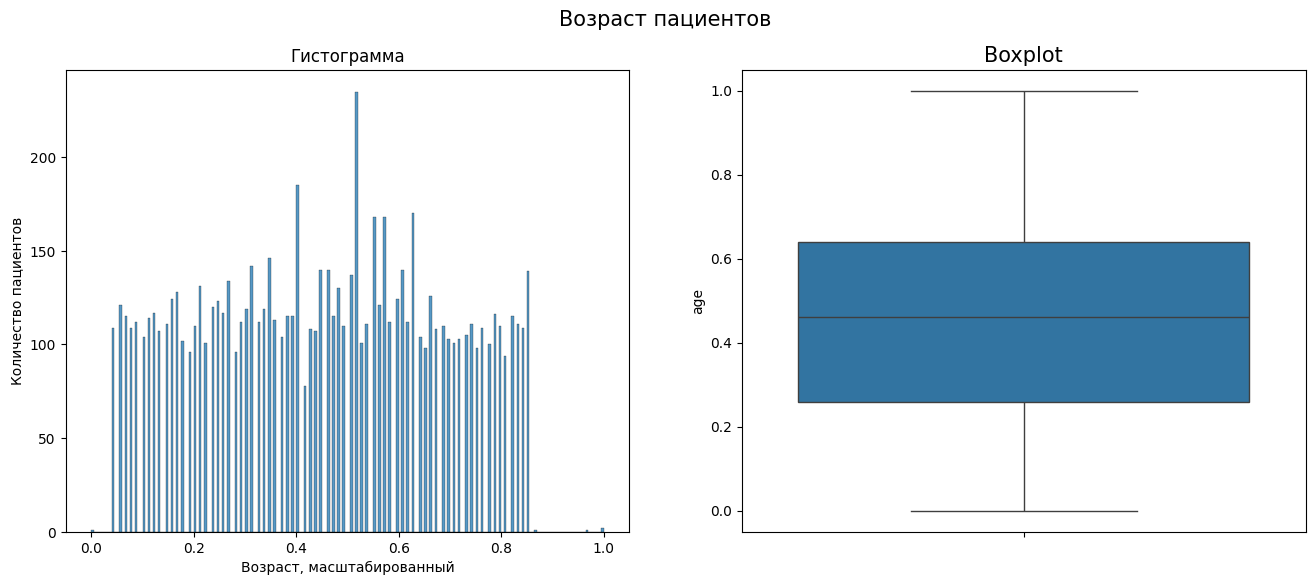

In [18]:
col_hist(train_X_y, 'age', 'Возраст пациентов', 'Возраст, масштабированный')

Возраст пациентов распределен достаточно равномерно с несколькими заметными пиками примерно на середине значений. Среднее значение очень близко к медианному. Есть малое количество значений около 0 и ближе к 1, чем основная масса. Скорее всего, это не ошибочные данные (до масштабирования), а редкие пациенты долгожители (около 1) или очень молодые (около 0). Удивительно, что между значениями околоо 0,85 и 1 такие большие пропуски, так что все-таки не исключена возможность ошибки, однако, оставим эти данные. 

### Холестерин


Холестерин - описательная статистика:
count    8685.000000
mean        0.501070
std         0.284716
min         0.000000
25%         0.267857
50%         0.499780
75%         0.746429
max         1.000000
Name: cholesterol, dtype: float64


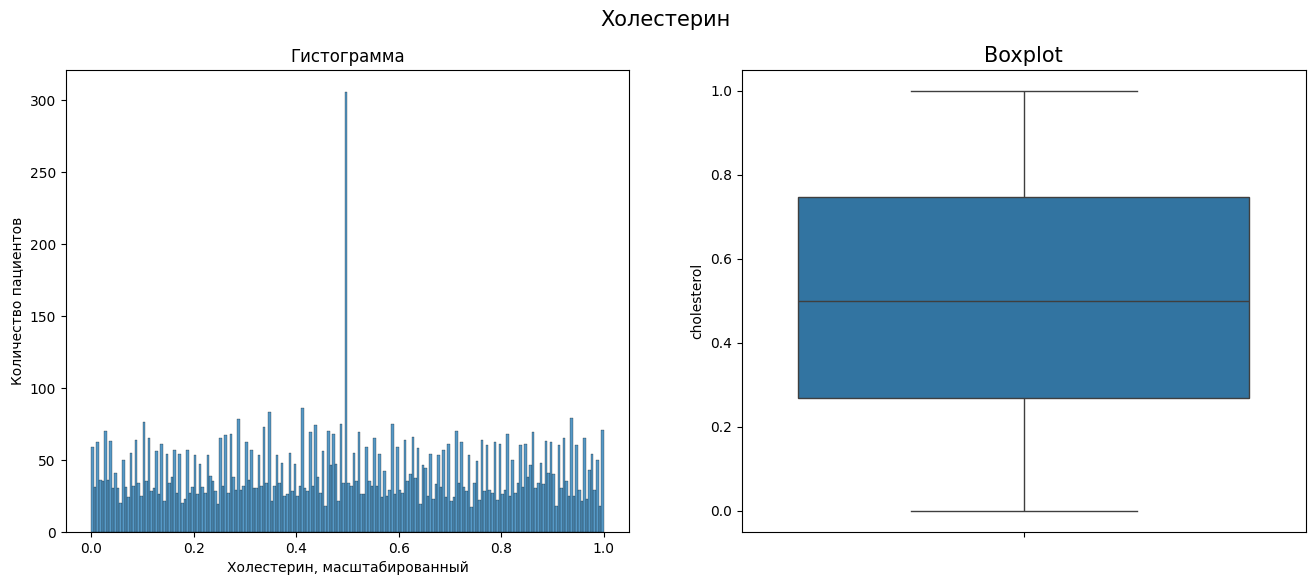

In [19]:
col_hist(train_X_y, 'cholesterol', 'Холестерин', 'Холестерин, масштабированный')

В значениях холестерина резко выделяется один пик. Возможно, это связано с округлением значения при сборе анализов. Например, если значение попало в референс нормальных значений 3.6–5.2 ммоль/л, то в такой ситуации могут записать не конкретное значение, а отметить норму и как значение может быть записано только одно из этих чисел.

В остальном, значения распределены с пиками (тоже, возможно, округление), но равномерно.

### Пульс


Пульс - описательная статистика:
count    8685.000000
mean        0.050658
std         0.023453
min         0.000000
25%         0.034830
50%         0.050412
75%         0.065995
max         1.000000
Name: heart_rate, dtype: float64


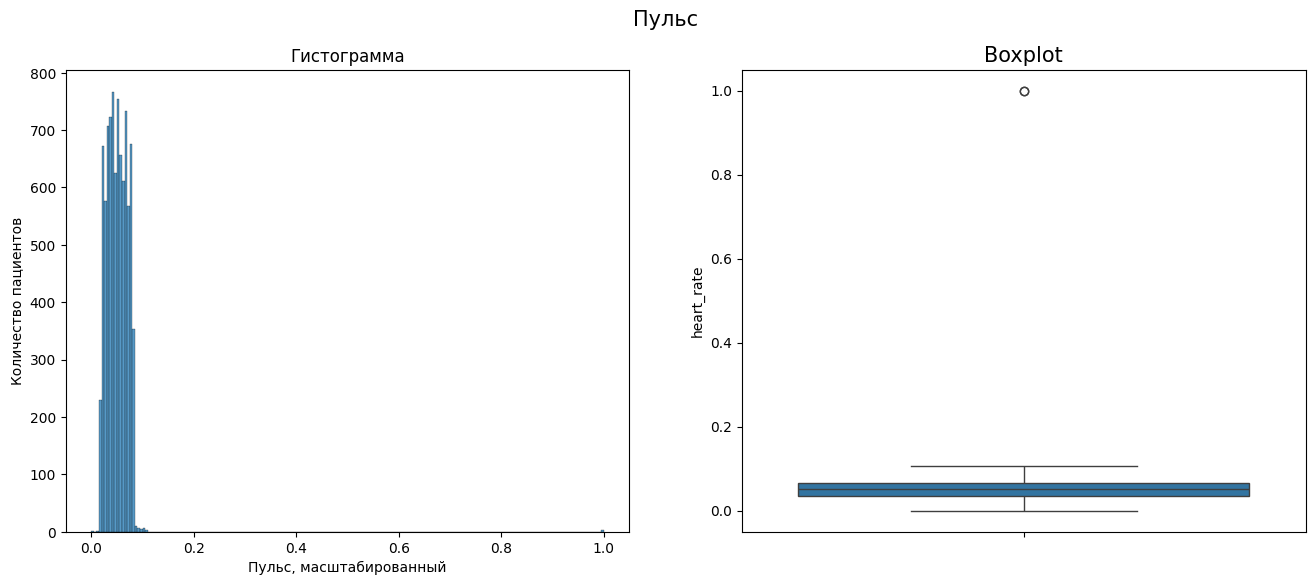

In [20]:
col_hist(train_X_y, 'heart_rate', 'Пульс', 'Пульс, масштабированный')

Есть очень заметный выброс на значении 1.0

In [21]:
train_X_y[train_X_y['heart_rate']==1.0]

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
1377,0.629213,0.49978,1.0,-1,-1,-1,-1,-1,0.50211,3,...,-1,0.5,0,0.203557,0.011843,0.002622,0,0.490323,0.616279,9547
2712,0.202247,0.49978,1.0,-1,-1,-1,-1,-1,0.50211,3,...,-1,0.5,0,0.092885,0.007805,0.000680,0,0.490323,0.616279,9611


Значение 1.0 повторяется дважды, часть других параметров совпадает, часть различается. Целевой параметр heart_attack_risk_(binary) равен 0 в обоих случаях. Так как сомнительное значение пульса встречается всего дважды, при этом медианное значение равно 0.05, а стандартное отклонение равно 0.02, данные значения исключим из базы данных. Предполагается какая-то ошибка, такая разница пульса не может быть даже если учитывать возможность физической нагрузки. При подготовке данных перед обучением модели мы снова масштабируем значения.

In [22]:
train_X_y = train_X_y[train_X_y['heart_rate'] != 1.0]


Пульс - описательная статистика:
count    8683.000000
mean        0.050439
std         0.018507
min         0.000000
25%         0.034830
50%         0.050412
75%         0.065995
max         0.105408
Name: heart_rate, dtype: float64


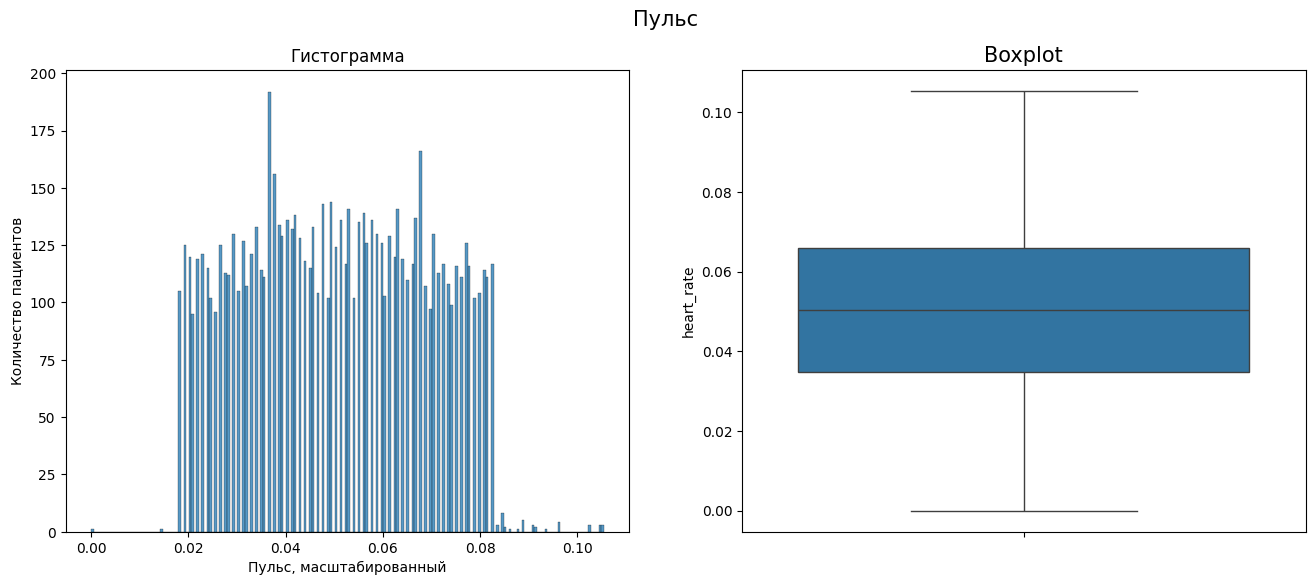

In [23]:
col_hist(train_X_y, 'heart_rate', 'Пульс', 'Пульс, масштабированный')

Теперь значения распределены более адекватно. На меньших и больших значениях встречаются более редкие значения, что вполне объяснимо для граничных значений.

### Диабет

diabetes
-1     241
 0    2937
 1    5505
Name: id, dtype: int64

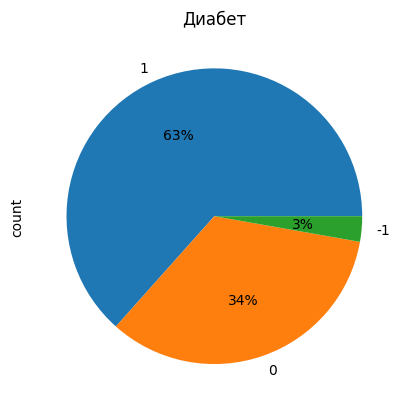

In [24]:
categ_pieplot(train_X_y, 'diabetes', 'Диабет')

У большинства пациентов (63%) был диагностирован диабет. 34% не имеют диабета, а 3% - пропущенные значения. Скорее всего, большое количество людей с диабетом связано с тем, что люди с хроническими болезнями чаще обследуются, чем те, кто ощущает себя здоровыми.

### Семейная история

family_history
-1     241
 0    4309
 1    4133
Name: id, dtype: int64

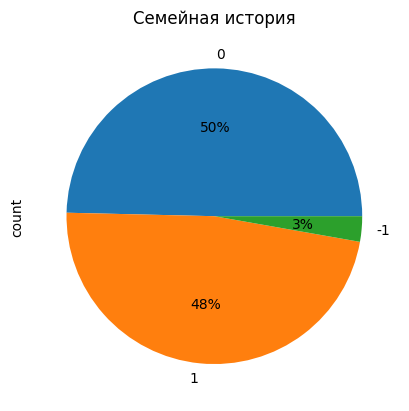

In [25]:
categ_pieplot(train_X_y, 'family_history', 'Семейная история')

Пациенты распределились почти пополам. Вероятнее всего, под этим признаком подразумевается наличие сердечных приступов в семейном анамнезе. Возможно, этот признак будет очень сильно влиять на целевой, посмотрим и решим в корреляционном анализе.

### Курение

smoking
-1     241
 0     820
 1    7622
Name: id, dtype: int64

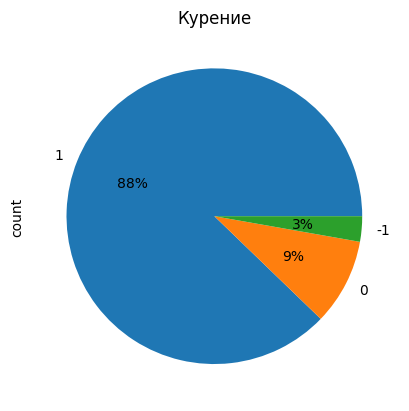

In [26]:
categ_pieplot(train_X_y, 'smoking', 'Курение')

Подавляющее большинство (88%) пациентов курит. Данные кажутся немного искаженными, но какие есть. Возможно, значение 1, вопреки ожидаемому, означает наоборот "не курит", тогда значения больше похоже на правду, если предположить, что не все пациенты признаются в этой привычке.

### Ожирение

obesity
-1     241
 0    4235
 1    4207
Name: id, dtype: int64

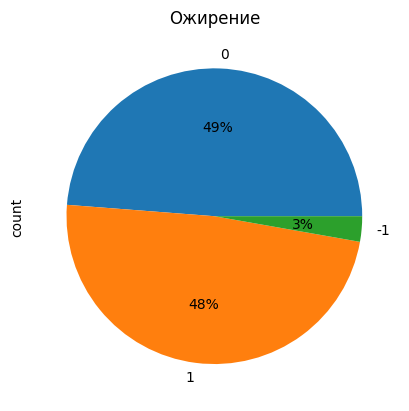

In [27]:
categ_pieplot(train_X_y, 'obesity', 'Ожирение')

Ожирение среди клиентов распределено одинаково: 50% значений говорит о наличии ожирение и 50% об отсутствии ожирения.

### Алкоголь

alcohol_consumption
-1     241
 0    3360
 1    5082
Name: id, dtype: int64

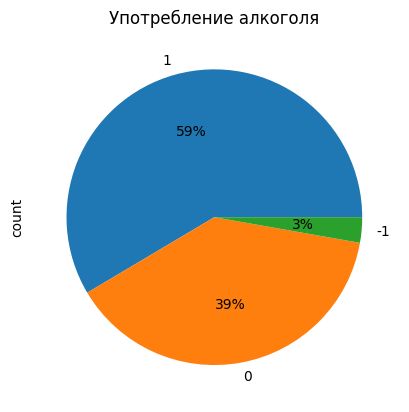

In [28]:
categ_pieplot(train_X_y, 'alcohol_consumption', 'Употребление алкоголя')

59% пациентов признают употребление алкоголя, 39% отрицают. Никаких интересных значений.

### Упражнения в неделю


Количество часов нагрузки в неделю - описательная статистика:
count    8683.000000
mean        0.503378
std         0.284843
min         0.000000
25%         0.263219
50%         0.502110
75%         0.748709
max         1.000000
Name: exercise_hours_per_week, dtype: float64


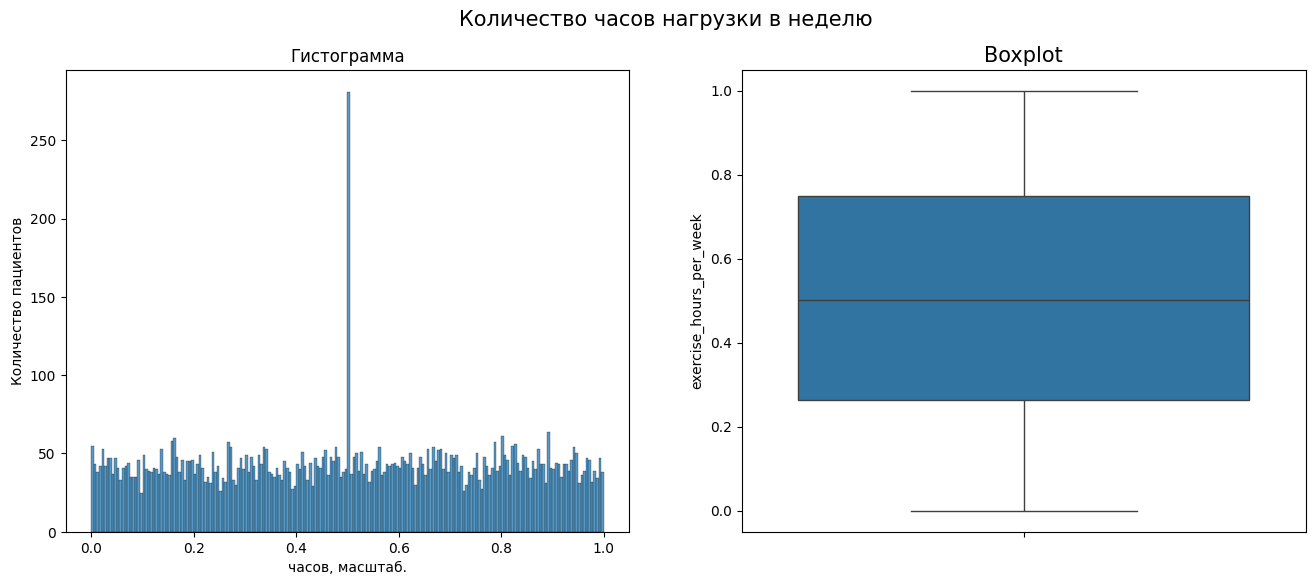

In [29]:
col_hist(train_X_y, 'exercise_hours_per_week', 'Количество часов нагрузки в неделю', 'часов, масштаб.')

Как и в случае с холестерином, здесь имеется очень высокий пик на одном значении. Остальные значения распределены достаточно равномерно. Пик, скорее всего, так же обусловлен каким-то особенным сбором данных изначально. Возможно, в этом значении идет какая-то минимальная норма и именно для этих пациентов опрос был про ее выполнение, а не про реальное количество часов нагрузки. Интересно, что остальные значения так плотно распределены. Не очень понятно, как могло собраться такое равномерное разнообразие значений.

### Диета

diet
0    2783
1    2863
2    2796
3     241
Name: id, dtype: int64

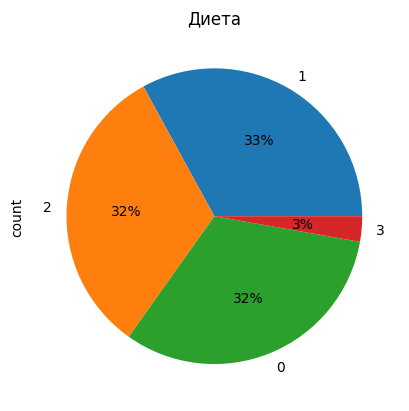

In [30]:
categ_pieplot(train_X_y, 'diet', 'Диета')

Вероятно, этот параметр означает соблюдение пациентами какой-либо диеты. Обычно это является следствием каких-либо заболеваний либо предпочтений (если в этом параметре присутствует вегетариантсво). Пока не очень ясно, является ли это утечкой из-за диеты по каким-то кардиологическим заболеваниям или же речь идет о других диетах. Постараемся уловить эту связь с хроническими болезнями и целевым признаком.

In [31]:
train_X_y.pivot_table(index='diet', columns='diabetes', values='id', aggfunc='count')

diabetes,-1,0,1
diet,,,
0,NaN,982.0,1801.0
1,NaN,983.0,1880.0
2,NaN,972.0,1824.0
3,241.0,NaN,NaN


In [32]:
train_X_y.pivot_table(index='diet', columns='heart_attack_risk_(binary)', values='id', aggfunc='count')

heart_attack_risk_(binary),0,1
diet,,
0,1813.0,970.0
1,1805.0,1058.0
2,1811.0,985.0
3,241.0,NaN


In [33]:
train_X_y.pivot_table(index='diet', columns='medication_use', values='id', aggfunc='count')

medication_use,-1,0,1
diet,,,
0,NaN,1383.0,1400.0
1,NaN,1456.0,1407.0
2,NaN,1372.0,1424.0
3,241.0,NaN,NaN


In [34]:
train_X_y.pivot_table(index='diet', columns='obesity', values='id', aggfunc='count')

obesity,-1,0,1
diet,,,
0,NaN,1379.0,1404.0
1,NaN,1442.0,1421.0
2,NaN,1414.0,1382.0
3,241.0,NaN,NaN


In [35]:
train_X_y.pivot_table(index='diet', columns='gender', values='id', aggfunc='count')

gender,0,1
diet,,
0,832,1951
1,867,1996
2,861,1935
3,85,156


Сделать какие-то выводы довольно сложно, по таблицам не наблюдается связи ни с одни из рассмотренных параметров. Единственное, что обратило на себя внимание - это то что диета №3 присутствует только в тех записях, где очень много пропусков по другим параметрам. Так же, предполагаю, что диета №0 - это отсутствие соблюдения какой-то специальной диеты.

Попробуем потом еще раз внимательно посмотреть на диету в корреляционном анализе. Сейчас еще раз посмотрим на значения с диетой номер 3.

In [36]:
train_X_y[train_X_y['diet']==3].sample(25)[['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day', 'income',
'bmi', 'triglycerides', 'blood_sugar', 'ck-mb',	'troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure']]

,age,cholesterol,heart_rate,exercise_hours_per_week,sedentary_hours_per_day,income,bmi,triglycerides,blood_sugar,ck-mb,troponin,systolic_blood_pressure,diastolic_blood_pressure
1794,0.719101,0.49978,0.063245,0.50211,0.49992,0.494889,0.494774,0.503603,0.788538,0.023155,0.000777,0.961290,0.534884
424,0.516854,0.49978,0.073327,0.50211,0.49992,0.494889,0.494774,0.503603,0.150198,0.005269,0.000485,0.335484,0.174419
16,0.449438,0.49978,0.063245,0.50211,0.49992,0.494889,0.494774,0.503603,0.233202,0.026692,0.000777,0.393548,0.255814
8509,0.651685,0.49978,0.036664,0.50211,0.49992,0.494889,0.494774,0.503603,0.239130,0.055790,0.060783,0.729032,0.779070
7299,0.348315,0.49978,0.088909,0.50211,0.49992,0.494889,0.494774,0.503603,0.330040,0.009540,0.000194,0.225806,0.302326
6381,0.471910,0.49978,0.048579,0.50211,0.49992,0.494889,0.494774,0.503603,0.424901,0.006003,0.000777,0.406452,0.244186
5547,0.584270,0.49978,0.043996,0.50211,0.49992,0.494889,0.494774,0.503603,0.181818,0.054155,0.003204,0.283871,0.197674
1047,0.393258,0.49978,0.073327,0.50211,0.49992,0.494889,0.494774,0.503603,0.096838,0.009106,0.001068,0.270968,0.255814
6137,0.516854,0.49978,0.071494,0.50211,0.49992,0.494889,0.494774,0.503603,0.126482,0.009507,0.002330,0.290323,0.395349
4532,0.404494,0.49978,0.091659,0.50211,0.49992,0.494889,0.494774,0.503603,0.081028,0.002029,0.006894,1.000000,1.000000


В этих данных (только с диетой номер 3) очень много дублирующихся значений в параметрах: значение холестирола, упражнения в неделю, сидячие часы в день, зарплата, триглицериды и ИМТ. Как уже упоминалось выше - скорее всего это связано с каким-то особенным сбором данных. И диета номер 3 связана с какой-то измененной формулировкой, но не смыслом и может на самом деле быть диетой 0 или другой из имеющихся. Либо же, такое выделение диеты говорит о том что данные собирали в каком-то определенном месте среди каких-то пациентов с особенностями питания (например, проживающих в санатории), поэтому данные заполнены так однообразно. В любом случае, эти данные мы не будем менять или исключать.

### Анамнез сердечных проблем

previous_heart_problems
-1     241
 0    4260
 1    4182
Name: id, dtype: int64

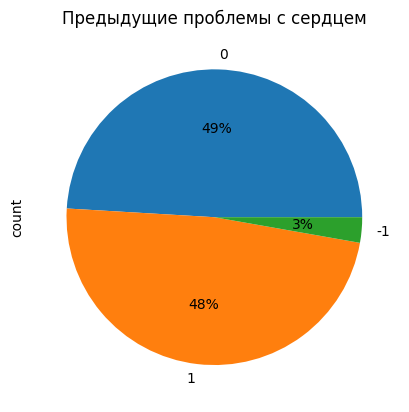

In [37]:
categ_pieplot(train_X_y, 'previous_heart_problems', 'Предыдущие проблемы с сердцем')

In [38]:
train_X_y.pivot_table(index='previous_heart_problems', columns='heart_attack_risk_(binary)', values='id', aggfunc='count')

heart_attack_risk_(binary),0,1
previous_heart_problems,,
-1,241.0,NaN
0,2743.0,1517.0
1,2686.0,1496.0


Как видно по диаграмме, пациентов с диагностированными ранее проблемами с сердцем примерно столько же, сколько не имевших проблем с сердцем. Стойкого влияния на риск сердечного приступа не замечено по сводной таблице. Этот признак не будем считать утечкой.

### Использование медикаментов

medication_use
-1     241
 0    4211
 1    4231
Name: id, dtype: int64

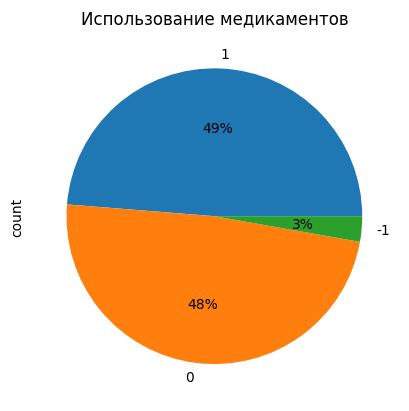

In [39]:
categ_pieplot(train_X_y, 'medication_use', 'Использование медикаментов')

In [40]:
train_X_y.pivot_table(index='previous_heart_problems', columns='medication_use', values='id', aggfunc='count')

medication_use,-1,0,1
previous_heart_problems,,,
-1,241.0,NaN,NaN
0,NaN,2155.0,2105.0
1,NaN,2056.0,2126.0


In [41]:
train_X_y.pivot_table(index='medication_use', columns='heart_attack_risk_(binary)', values='id', aggfunc='count')

heart_attack_risk_(binary),0,1
medication_use,,
-1,241.0,NaN
0,2709.0,1502.0
1,2720.0,1511.0


Соотношение пациентов, использующих медикаменты и не использующих - примерно пополам. При этом нет заметной связи с имеющимися в анамнезе сердечными проблемами, либо с риском сердечного приступа.

### Уровень стресса


Уровень стресса - описательная статистика:
count    8683.000000
mean        5.313141
std         3.022292
min        -1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: stress_level, dtype: float64


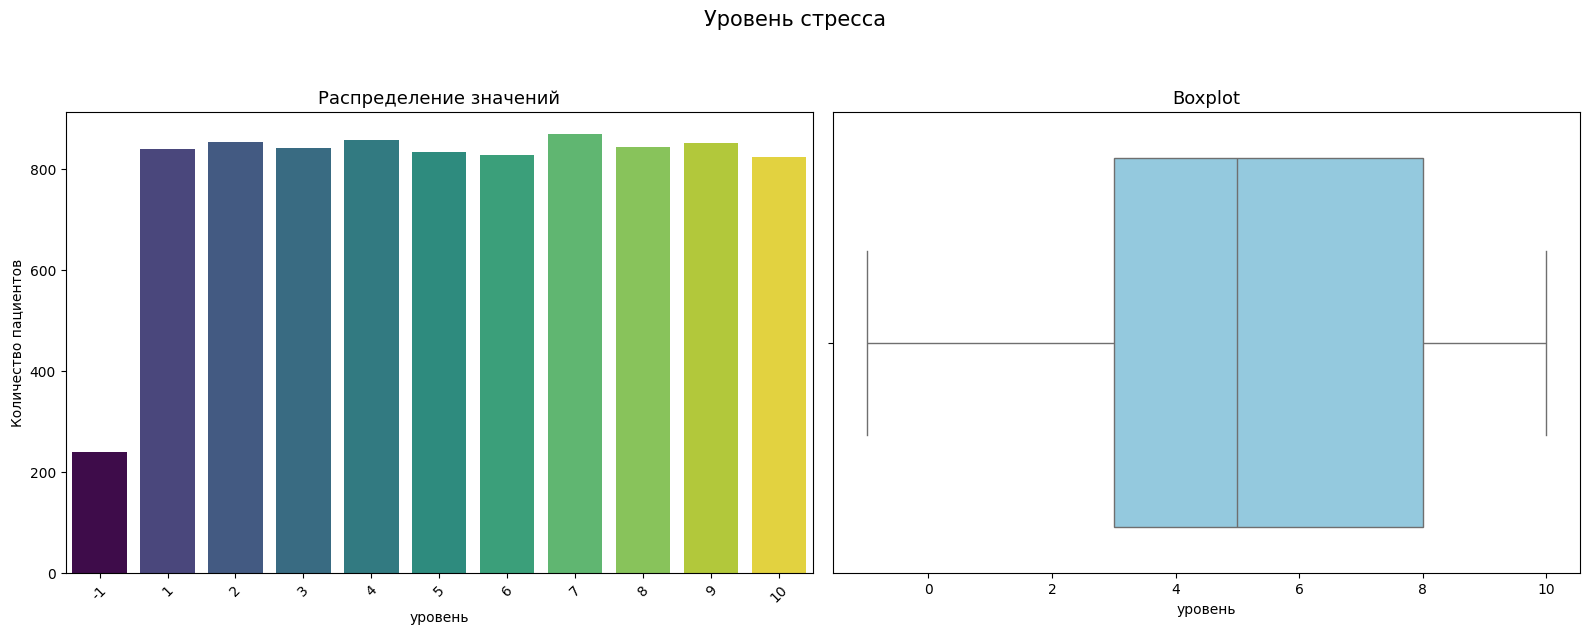


Уникальные значения (11):
stress_level
-1     241
 1     840
 2     854
 3     841
 4     857
 5     833
 6     828
 7     869
 8     844
 9     852
 10    824
Name: count, dtype: int64


In [42]:
col_count(train_X_y, 'stress_level', 'Уровень стресса', 'уровень')

### Часы сидения в день


Часы сидя - описательная статистика:
count    8683.000000
mean        0.499164
std         0.285373
min         0.000000
25%         0.255741
50%         0.499920
75%         0.744623
max         1.000000
Name: sedentary_hours_per_day, dtype: float64


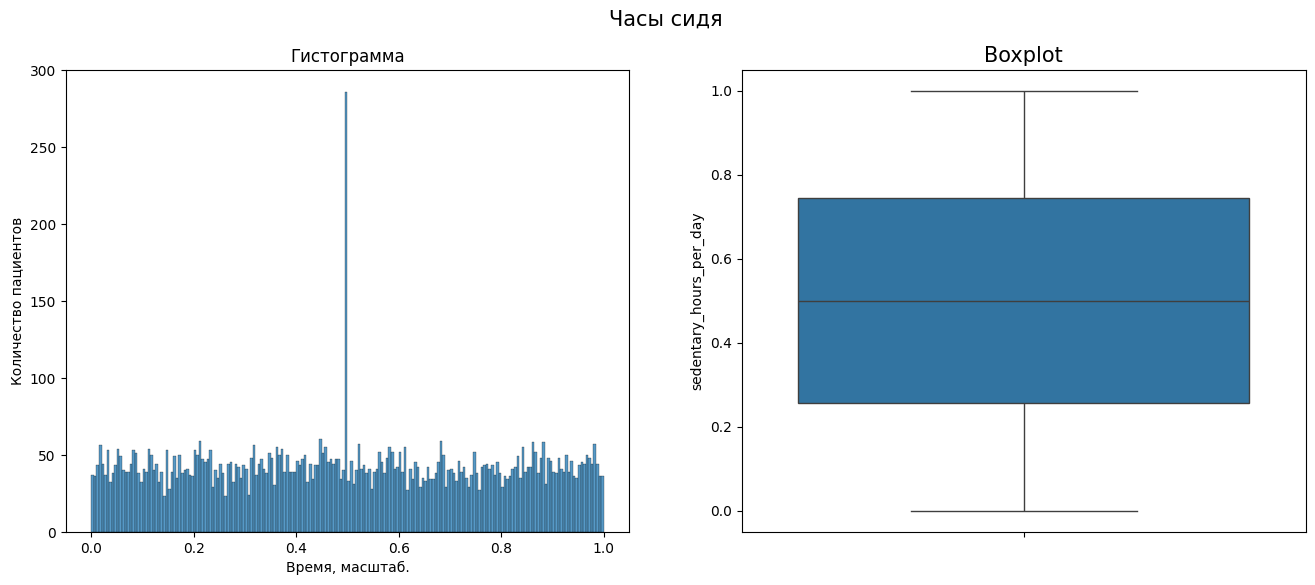

In [43]:
col_hist(train_X_y, 'sedentary_hours_per_day', 'Часы сидя', 'Время, масштаб.')

Снова достаточно равномерное распределение с одной пиковой точкой на значении 0,49992. Это те самые значения, которые мы видели дублирующимися в пункте по диете, ожидаемый результат.

### Доход


Доход - описательная статистика:
count    8683.000000
mean        0.496055
std         0.284731
min         0.000000
25%         0.251883
50%         0.494889
75%         0.741073
max         1.000000
Name: income, dtype: float64


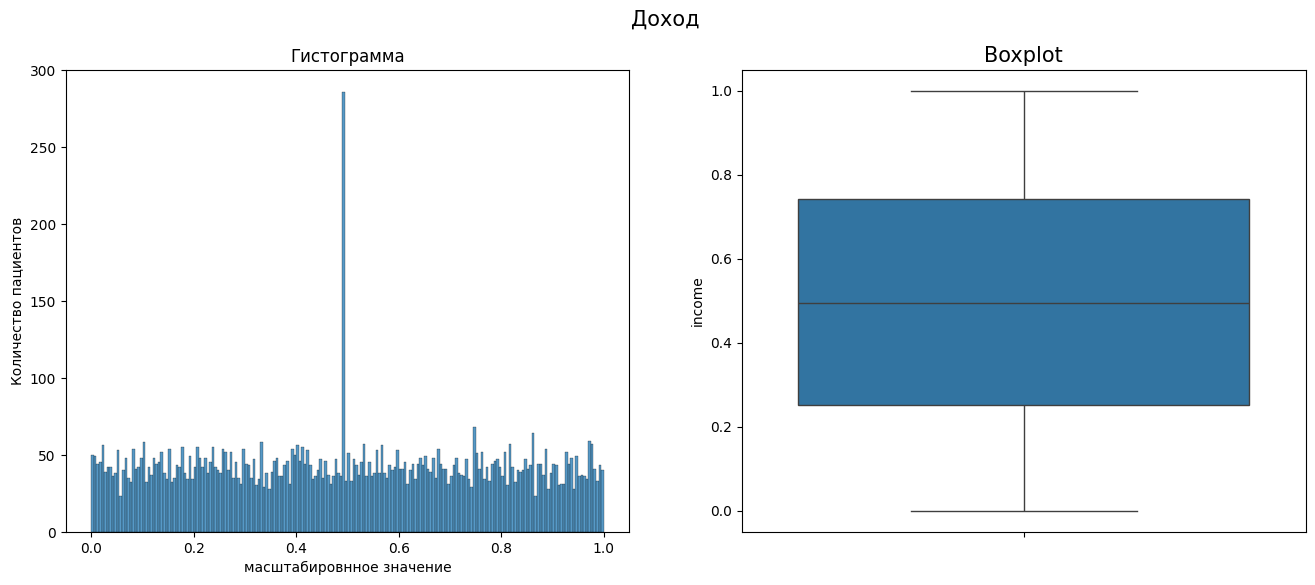

In [44]:
col_hist(train_X_y, 'income', 'Доход', 'масштабировнное значение')

Аналогично предыдущему пункту - один пик, который вызван вливанием данных с отличающегося источника.

### ИМТ


Индекс массы тела - описательная статистика:
count    8683.000000
mean        0.496774
std         0.282594
min         0.000000
25%         0.254165
50%         0.494774
75%         0.737021
max         1.000000
Name: bmi, dtype: float64


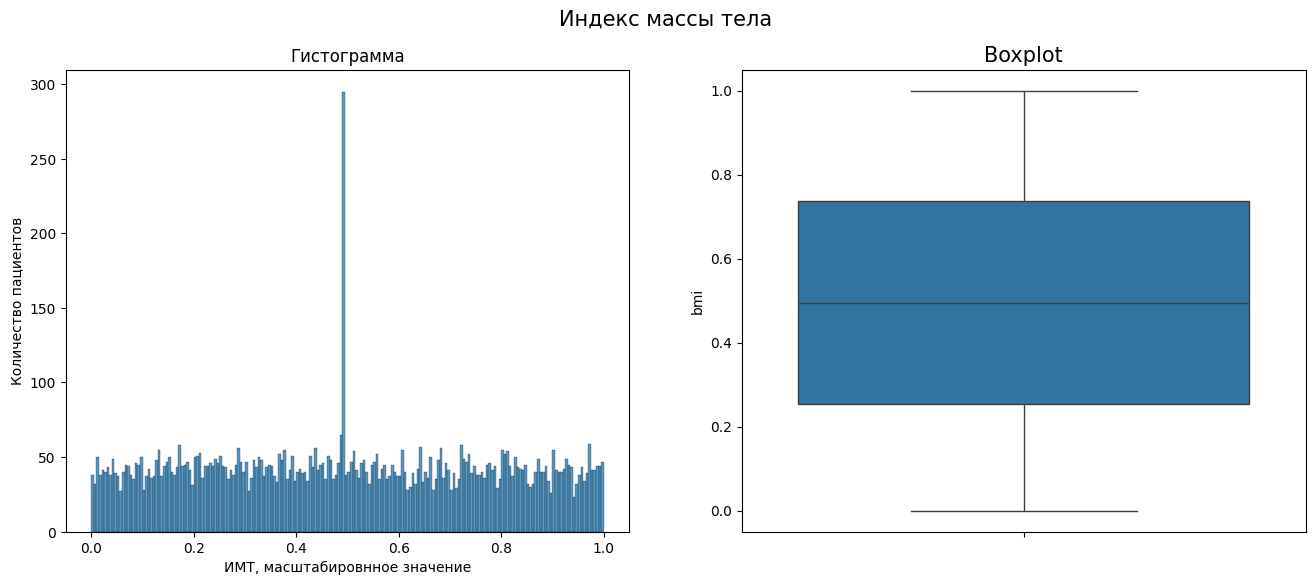

In [45]:
col_hist(train_X_y, 'bmi', 'Индекс массы тела', 'ИМТ, масштабировнное значение')

Опять тот же пик из-за одинаковых значений и относительно равномерное распределение остальных.

### Триглицериды


Триглицериды - описательная статистика:
count    8683.000000
mean        0.505485
std         0.286353
min         0.000000
25%         0.263636
50%         0.503603
75%         0.750649
max         1.000000
Name: triglycerides, dtype: float64


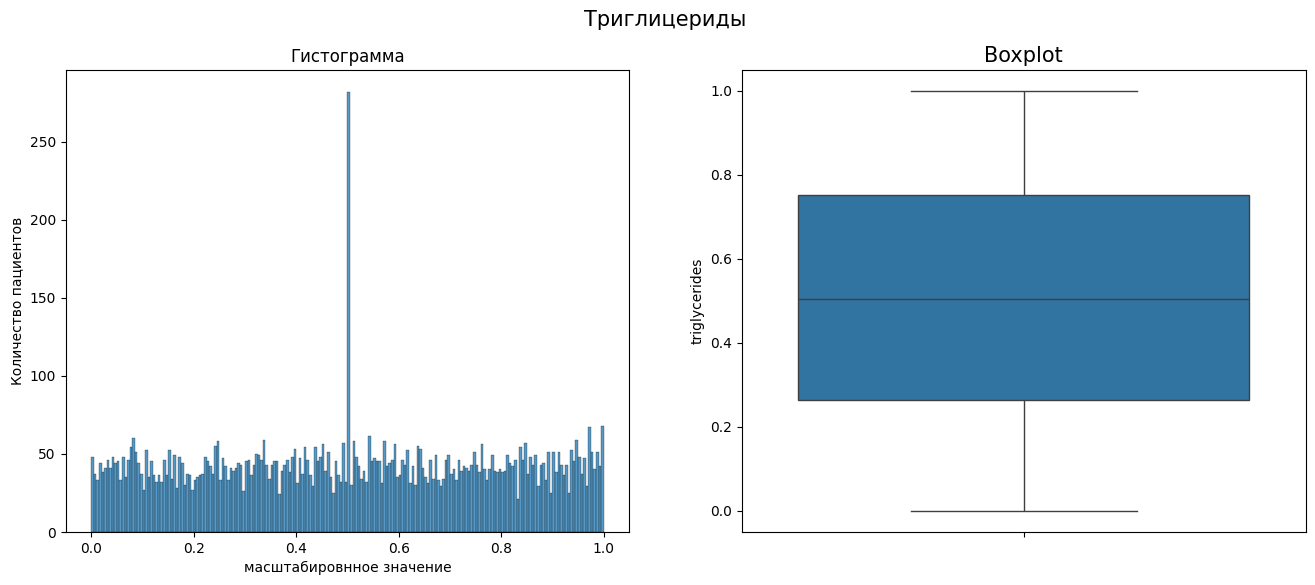

In [46]:
col_hist(train_X_y, 'triglycerides', 'Триглицериды', 'масштабировнное значение')

Опять то же распределение с одним пиком основным из-за дубликатов.

### Физическая активность


Физическая активность д/нед. - описательная статистика:
count    8683.000000
mean        3.383163
std         2.368646
min        -1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max         7.000000
Name: physical_activity_days_per_week, dtype: float64


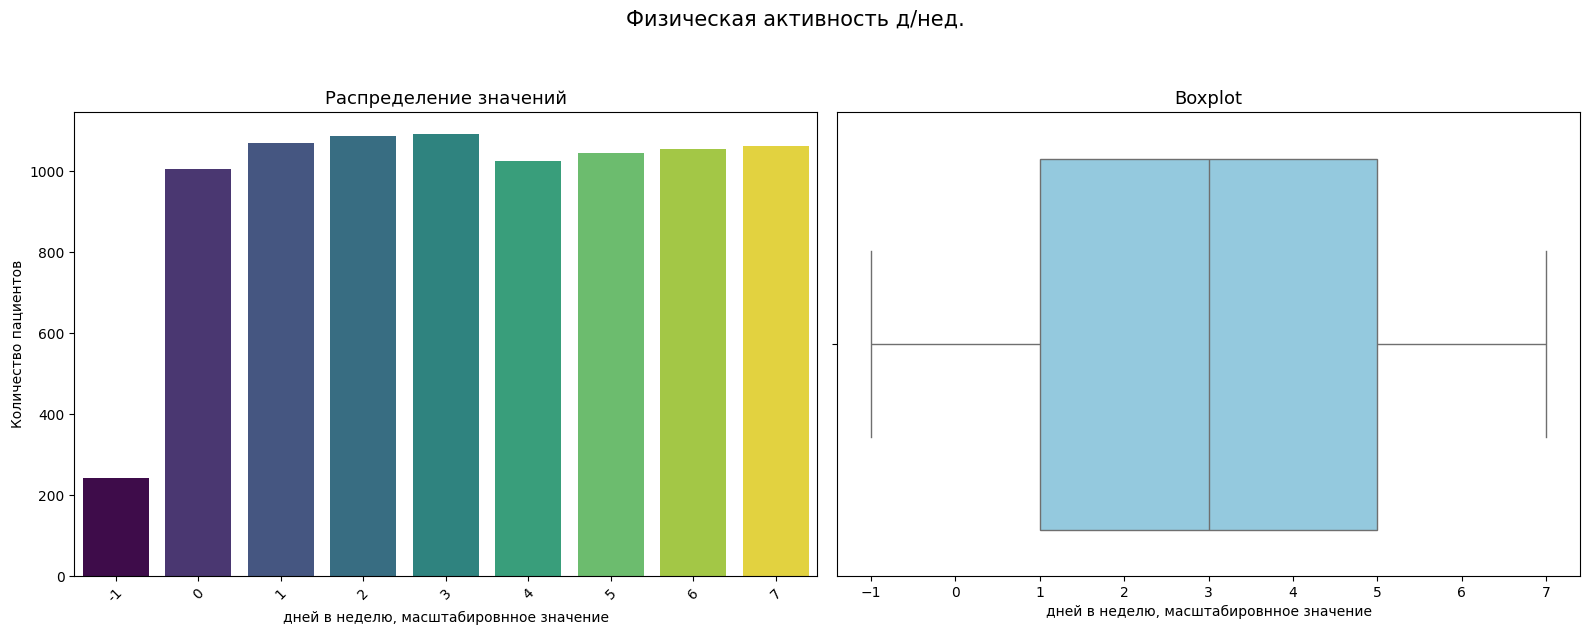


Уникальные значения (9):
physical_activity_days_per_week
-1     241
 0    1006
 1    1069
 2    1087
 3    1091
 4    1025
 5    1046
 6    1055
 7    1063
Name: count, dtype: int64


In [47]:
col_count(train_X_y, 'physical_activity_days_per_week', 'Физическая активность д/нед.', 'дней в неделю, масштабировнное значение')

Значения очень близки. Опять выделяются 241 значение без данных.

### Сон


Сон - описательная статистика:
count    8683.000000
mean        0.503665
std         0.327662
min         0.000000
25%         0.170000
50%         0.500000
75%         0.830000
max         1.000000
Name: sleep_hours_per_day, dtype: float64


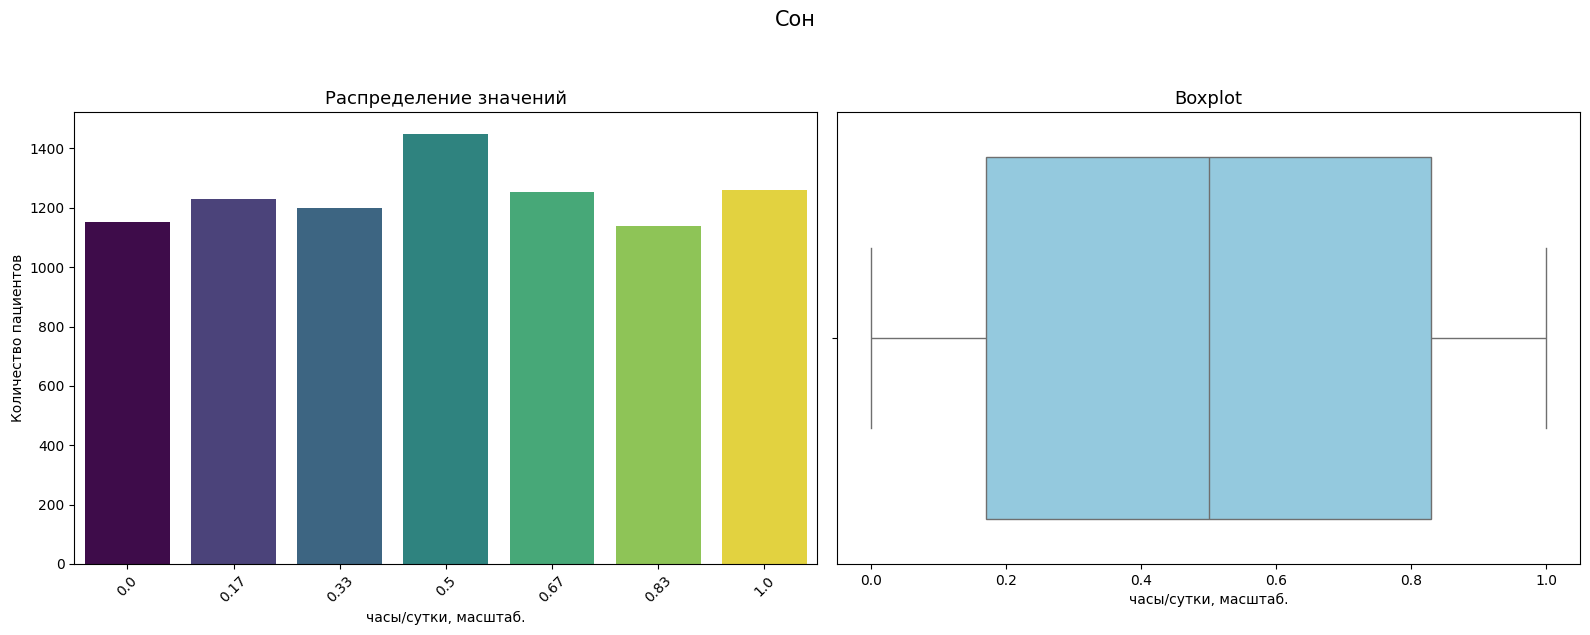


Уникальные значения (7):
sleep_hours_per_day
0.00    1153
0.17    1231
0.33    1200
0.50    1449
0.67    1252
0.83    1137
1.00    1261
Name: count, dtype: int64


In [48]:
col_count(train_X_y, 'sleep_hours_per_day', 'Сон', 'часы/сутки, масштаб.')

Часы сна распределены волннобразно, выбросов нет.

### Риск сердечного приступа (целевой)

heart_attack_risk_(binary)
0    5670
1    3013
Name: id, dtype: int64

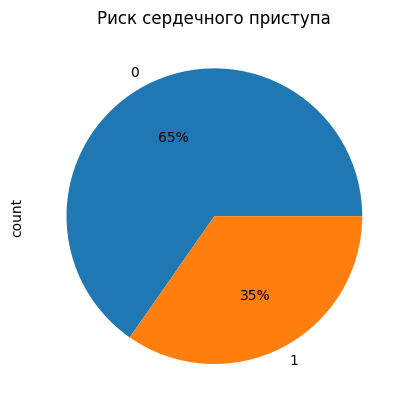

In [49]:
categ_pieplot(train_X_y, 'heart_attack_risk_(binary)', 'Риск сердечного приступа')

Признак бинарный, у 65% наблюдаемых нет риска сердечного приступа. У 35% такой риск присутствует. Корреляцию с другими признаками посмотрим в корреляционном анализе далее.

### Сахар в крови


Сахар в крови - описательная статистика:
count    8683.000000
mean        0.227357
std         0.076630
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood_sugar, dtype: float64


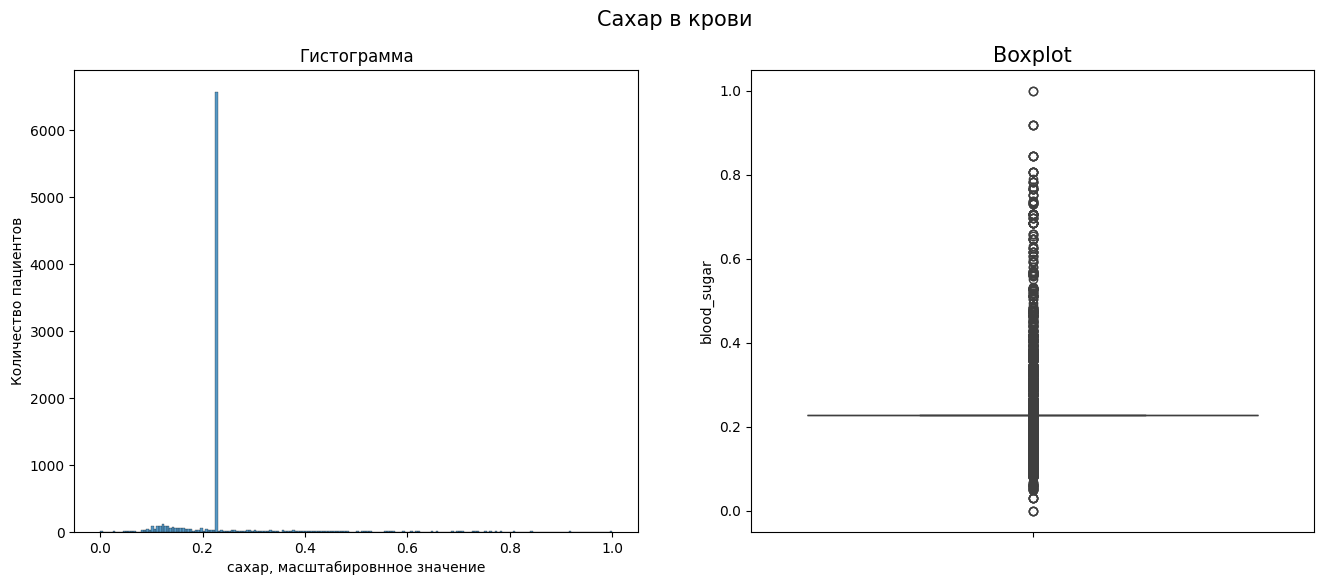

In [50]:
col_hist(train_X_y, 'blood_sugar', 'Сахар в крови', 'сахар, масштабировнное значение')

In [54]:
train_X_y.query('blood_sugar > 0.227 & blood_sugar < 0.2271')

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0.359551,0.732143,0.074244,1,1,1,1,1,0.535505,1,...,3,0.33,0,0.227018,0.048229,0.036512,1,0.212903,0.709302,2664
2,0.606742,0.860714,0.055912,1,0,1,1,1,0.944001,2,...,2,1.00,0,0.227018,0.048229,0.036512,0,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0,0,1,0,1,0.697023,0,...,0,0.33,1,0.227018,0.048229,0.036512,0,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0,0,1,0,1,0.412878,1,...,5,1.00,1,0.227018,0.048229,0.036512,1,0.619355,0.441860,4047
5,0.168539,0.764286,0.057745,0,1,1,1,1,0.082682,1,...,6,0.83,0,0.227018,0.048229,0.036512,1,0.464516,0.418605,5817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8678,0.314607,0.142857,0.082493,1,0,1,0,0,0.932011,2,...,7,0.33,0,0.227018,0.048229,0.036512,0,0.664516,0.511628,466
8679,0.651685,0.253571,0.020165,1,1,1,1,1,0.609064,1,...,7,0.83,1,0.227018,0.048229,0.036512,1,0.361290,0.500000,6265
8682,0.471910,0.067857,0.023831,1,0,1,0,1,0.076336,2,...,1,0.83,0,0.227018,0.048229,0.036512,1,0.374194,0.558140,5390
8683,0.595506,0.000000,0.075160,0,1,1,0,1,0.371759,2,...,4,0.50,0,0.227018,0.048229,0.036512,1,0.477419,0.744186,860


Подавляющее число значений равны друг другу - больше 6500 вхождений одного и того же значения. От этого boxplot выявил огромное количество выбросов (все остальные значения, по сути). Сахар в крови - достаточно важный показатель для оценки здоровья организма и нагрузки на сердце. Однако, такое количество одинаковых значений может оказаться бесполезным. Вполне возможно, что даже такоое однообразие значений может быть результативным, но именно в сочетании с другими параметрами (например, наличие диабета, как самая очевидная связь). Посмотрим внимательно на корреляционном анализе, прежде чем принимать решение по поводу необходимости таких данных.

### Креатинкиназа MB


Креатинкиназа MB - описательная статистика:
count    8683.000000
mean        0.048168
std         0.075537
min         0.000000
25%         0.048229
50%         0.048229
75%         0.048229
max         1.000000
Name: ck-mb, dtype: float64


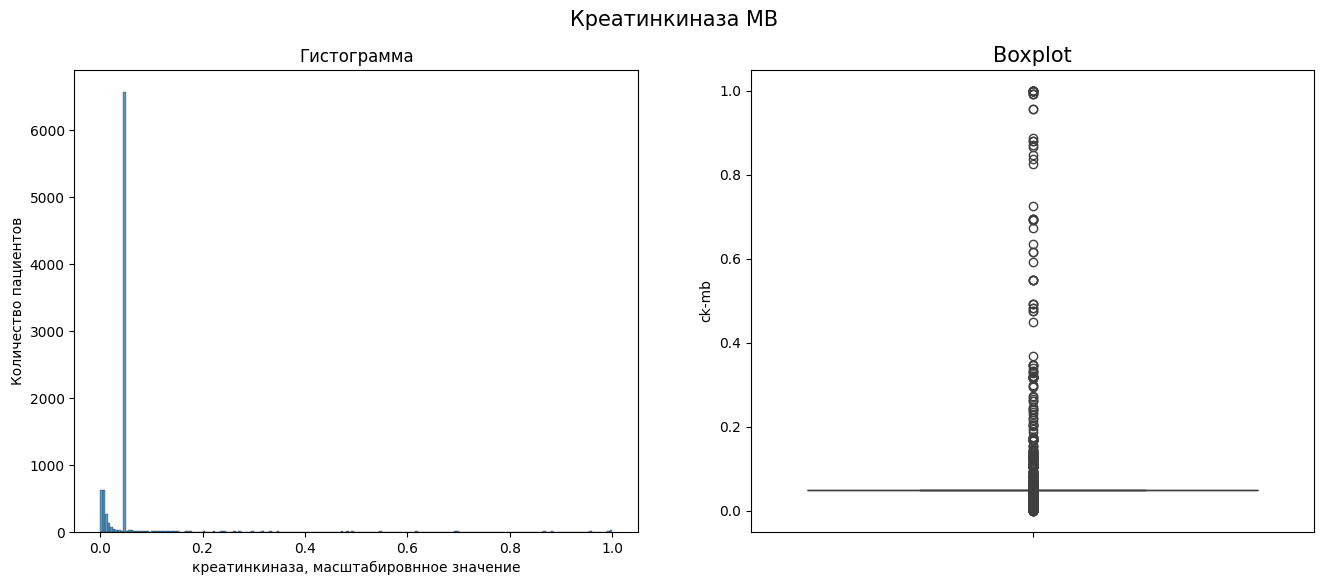

In [55]:
col_hist(train_X_y, 'ck-mb', 'Креатинкиназа MB', 'креатинкиназа, масштабировнное значение')

Так же, как и в сахаре - огромное значение одинаковых значений. Скорее всего, это даже одни и те же записи. Сам параметр характеризует повреждение сердечной мышцы и используется для диагноза инфаркта миакарда. В данном проекте эта характеристика будет считаться утечкой данных, поэтому ее будет необходимо удалить. Сделаем это после корреляционного анализа.

### Тропонин


Тропонин - описательная статистика:
count    8683.000000
mean        0.036697
std         0.060161
min         0.000000
25%         0.036512
50%         0.036512
75%         0.036512
max         1.000000
Name: troponin, dtype: float64


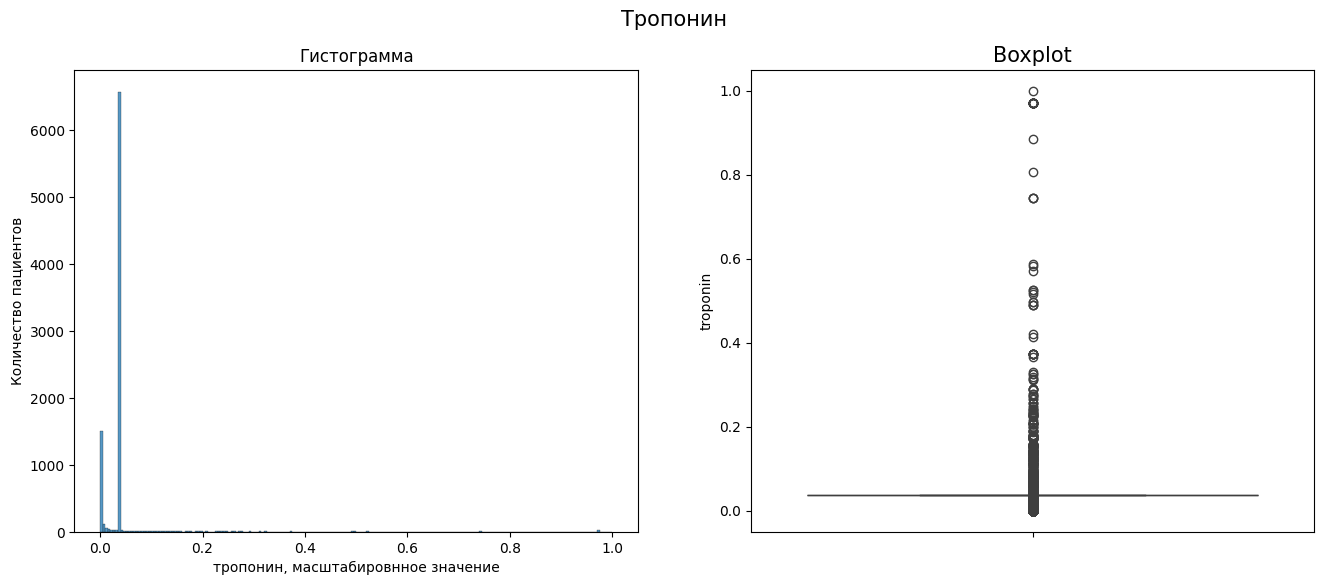

In [56]:
col_hist(train_X_y, 'troponin', 'Тропонин', 'тропонин, масштабировнное значение')

Аналогично - огромный пик на одном и том же значении в 6500+ значений. И, как и кретинкиназа, это снова анализ, связанный с диагностикой инфаркта, а значит - утечка данных.

### Пол

gender
0    2645
1    6038
Name: id, dtype: int64

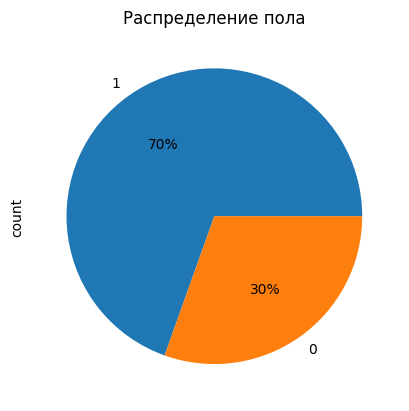

In [58]:
categ_pieplot(train_X_y, 'gender', 'Распределение пола')

Среди данных присутствует неравномерность: мужчин 70%, а женщин 30%, отличие больше чем в два раза.

### Систолическое (верхнее) артериальное давление


Систолическое артериальное давление - описательная статистика:
count    8683.000000
mean        0.450286
std         0.170203
min         0.000000
25%         0.303226
50%         0.445161
75%         0.600000
max         1.000000
Name: systolic_blood_pressure, dtype: float64


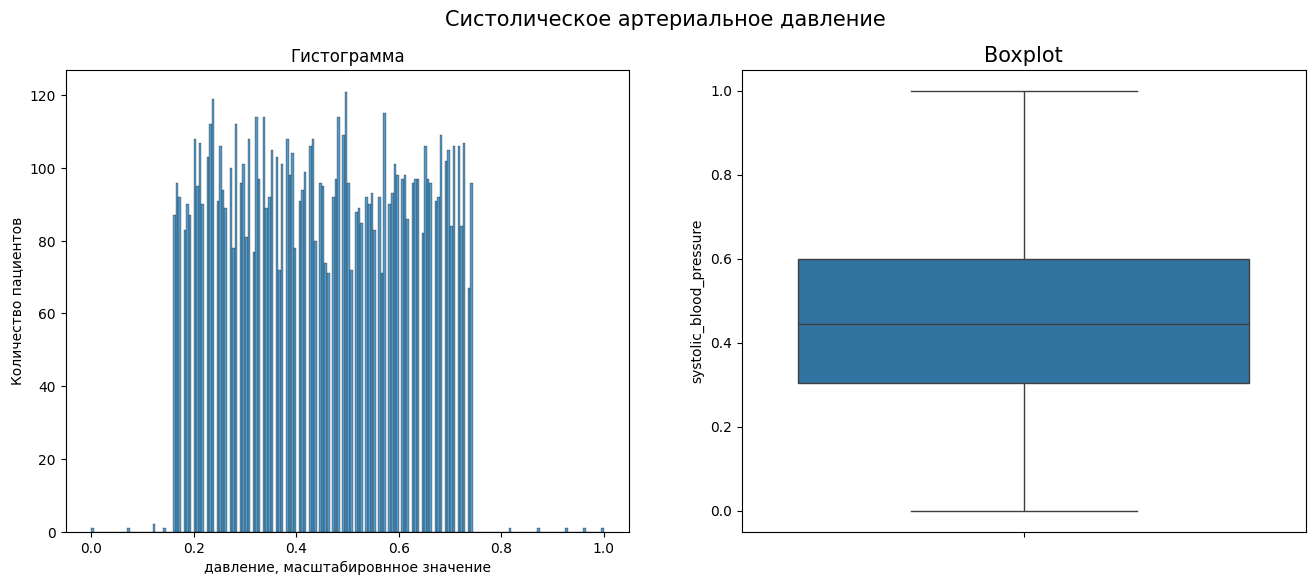

In [59]:
col_hist(train_X_y, 'systolic_blood_pressure', 'Систолическое артериальное давление', 'давление, масштабировнное значение')

Большая часть значений находится между 0,15 и 0,75. Присутствуют редкие значения ниже и выше этого диапазона.

### Диастолическое (нижнее) артериальное давление


Диастолическое артериальное давление - описательная статистика:
count    8683.000000
mean        0.497607
std         0.171841
min         0.000000
25%         0.348837
50%         0.500000
75%         0.651163
max         1.000000
Name: diastolic_blood_pressure, dtype: float64


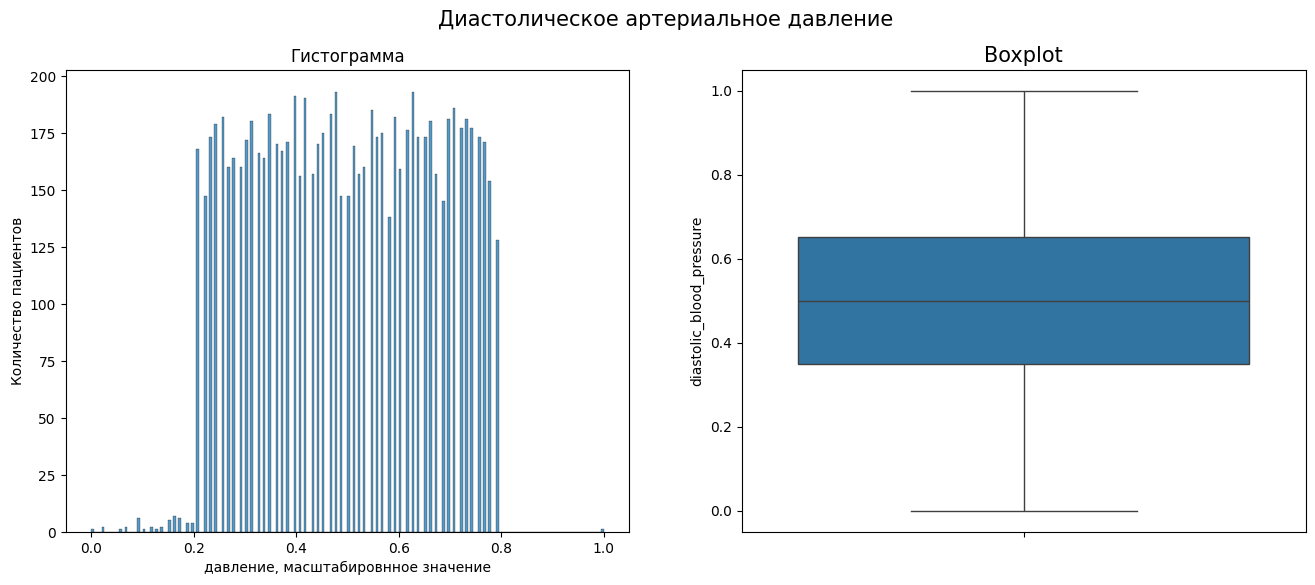

In [60]:
col_hist(train_X_y, 'diastolic_blood_pressure', 'Диастолическое артериальное давление', 'давление, масштабировнное значение')

Диастолическое давление распределено подобно систолическому - с редкими значениями скраю от основного столба значений. Такие единичные значения выглядят немного сомнительно, но даже если это ошибочные значения - они не должны очень сильно влиять на модель при таком большом количестве записей. Поэтому оставим их.

### Корреляционный анализ

In [61]:
interval_cols = ['age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day', 'income',
'bmi', 'triglycerides', 'blood_sugar', 'ck-mb',	'troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure']
phik_overview = train_X_y.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
print(phik_overview.shape) 

(26, 26)


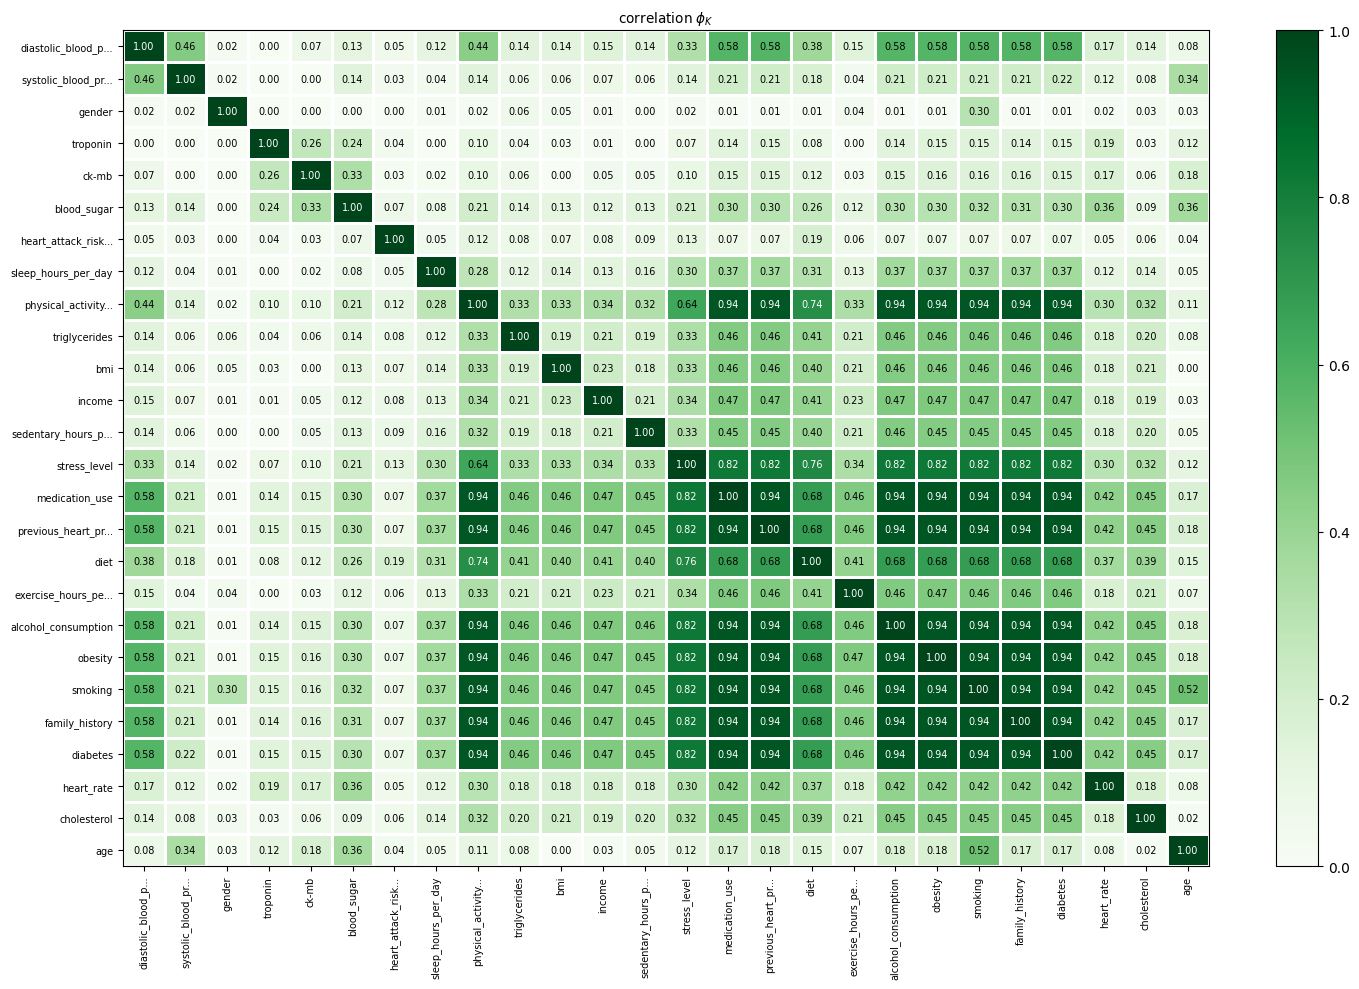

In [63]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=0.7,
    figsize=(15, 10)
) 